In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report,f1_score,accuracy_score
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from sklearn import svm
import itertools

In [2]:
def dataPrepare():
    data = pd.read_csv("Data/benign_traffic.csv")
    data['Class']=0
    udp = pd.read_csv("Data/mirai_attacks/udp.csv")
    udp['Class'] = 1

    ack = pd.read_csv("Data/mirai_attacks/ack.csv")
    ack['Class'] = 1

    scan = pd.read_csv("Data/mirai_attacks/scan.csv")
    scan['Class'] = 1

    syn = pd.read_csv("Data/mirai_attacks/syn.csv")
    syn['Class'] = 1

    udpplain = pd.read_csv("Data/mirai_attacks/udpplain.csv")
    udpplain['Class'] = 1

    
    g_combo = pd.read_csv("Data/gafgyt_attacks/combo.csv")
    g_combo['Class'] = 1

    g_junk = pd.read_csv("Data/gafgyt_attacks/junk.csv")
    g_junk['Class'] = 1

    g_scan = pd.read_csv("Data/gafgyt_attacks/scan.csv")
    g_scan['Class'] = 1

    g_tcp = pd.read_csv("Data/gafgyt_attacks/tcp.csv")
    g_tcp['Class'] = 1

    g_udp = pd.read_csv("Data/gafgyt_attacks/udp.csv")
    g_udp['Class'] = 1


    frames = [data, udp, ack, scan, syn, udpplain
              ,g_combo, g_junk, g_scan, g_tcp, g_udp]


    result = pd.concat(frames, ignore_index=True)
    return result

In [3]:
def dataPreprocessing(data):
    print('------')


    count_class = pd.value_counts(data['Class'],sort=True).sort_index()
    print(count_class)

    print('------')
    X = data.iloc[:, data.columns != 'Class']
    y = data.iloc[:, data.columns == 'Class']

    positive_sample_count = len(data[data.Class == 1])
    print( positive_sample_count)
    
    negative_sample_index = np.array(data[data.Class == 0].index)
    print(negative_sample_index[:5])

    positive_sample_index = data[data.Class == 1].index

    random_positive_sample_index = np.random.choice(positive_sample_index, int(1*len(data[data.Class == 0])), replace=False)

    

    print(random_positive_sample_index[:5])

    under_sample_index = np.concatenate([random_positive_sample_index, negative_sample_index])
    under_sample_data = data.iloc[under_sample_index, :]
    X_under_sample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
    y_under_sample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    X_train_under_sample, X_test_under_sample, y_train_under_sample, y_test_under_sample = train_test_split(
        X_under_sample,
        y_under_sample,
        test_size=0.3,
        random_state=0)
    print(len(X_train_under_sample))
    print(len(X_test_under_sample))

    return X_train, X_test, y_train, y_test,X_train_under_sample, X_test_under_sample, y_train_under_sample, y_test_under_sample


In [10]:

def plot_confusion_matrix(confusion_matrix, classes):
    plt.figure()
    plt.imshow(confusion_matrix, interpolation='nearest',cmap=plt.cm.Blues)
    plt.title('confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, confusion_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Plots/confusion_matrix.png', dpi=200, format='png', bbox_inches='tight')

    plt.show()
    print(confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1]))
    print(confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[1,0]))
    print((confusion_matrix[0,0]+confusion_matrix[1,1])/(confusion_matrix[0,0]+confusion_matrix[0,1]+confusion_matrix[1,1]+confusion_matrix[1,0]))
    print('*********************************************************************************')

In [11]:
def show_values(pc, fmt="%.2f", **kw):

    pc.update_scalarmappable()
    ax = pc.axes

    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):

    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):

    fig, ax = plt.subplots()    

    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    plt.xlim( (0, AUC.shape[1]) )

    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    plt.colorbar(c)

    show_values(c)

    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    fig = plt.gcf()

    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


In [12]:
result = dataPrepare()

In [13]:
result.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Class
0,1.000000,60.000000,0.000000,1.000000,60.0000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,0
1,1.000000,590.000000,0.000000,1.000000,590.0000,0.000000e+00,1.000000,590.000000,0.000000,1.000000,...,0.0,0.0,6.302352,416.121686,113.526005,416.121686,12888.15384,0.0,0.0,0
2,1.942585,590.000000,0.000000,1.965145,590.0000,1.160000e-10,1.988244,590.000000,0.000000,1.998818,...,0.0,0.0,7.301607,439.935392,121.229684,439.935392,14696.63622,0.0,0.0,0
3,1.000000,60.000000,0.000000,1.000000,60.0000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,0
4,1.979600,66.061831,35.996177,1.987709,66.0371,3.599862e+01,1.995886,66.012367,35.999847,1.999588,...,0.0,0.0,1.000000,72.000000,0.000000,72.000000,0.00000,0.0,0.0,0


In [14]:
X_train, X_test, y_train, y_test,X_train_under_sample, X_test_under_sample, y_train_under_sample, y_test_under_sample=dataPreprocessing(result)

------
0     62154
1    766106
Name: Class, dtype: int64
------
766106
[0 1 2 3 4]
[512148 246481 274282 822569 761123]
87015
37293


Accuracy Score :  0.9999463706325584


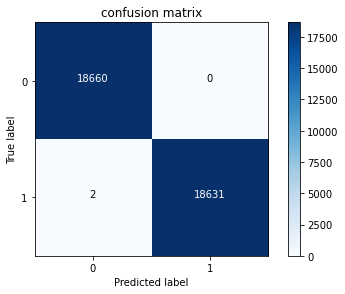

1.0
0.9998926635539097
0.9999463706325584
*********************************************************************************


In [15]:
best_c_param=10

lr = RandomForestClassifier()
lr.fit(X_train_under_sample, y_train_under_sample.values.ravel())


y_undersample_pred = lr.predict(X_test_under_sample.values)
print("Accuracy Score : ",accuracy_score(y_undersample_pred,y_test_under_sample.values))
conf_matrix = confusion_matrix(y_test_under_sample,y_undersample_pred)

np.set_printoptions(precision=2)
class_names = [0,1]

plot_confusion_matrix(conf_matrix
                     , classes=class_names)

In [16]:
print ('\n*Classification Report:\n', classification_report(y_test_under_sample,y_undersample_pred))


*Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18660
           1       1.00      1.00      1.00     18633

    accuracy                           1.00     37293
   macro avg       1.00      1.00      1.00     37293
weighted avg       1.00      1.00      1.00     37293



[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
plotMat: [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
support: [18660, 18633]


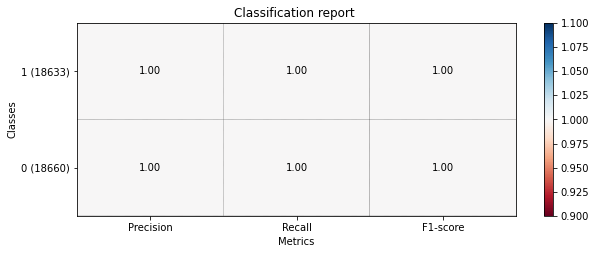

In [17]:
sampleClassificationReport = """precision    recall  f1-score   support

                   0       1.00      1.00      1.00     18660
                   1       1.00      1.00      1.00     18633

           macro avg       1.00      1.00      1.00     37293
        weighted avg       1.00      1.00      1.00     37293"""


plot_classification_report(sampleClassificationReport)
plt.savefig('Plots/plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
plt.plot()
plt.show()
plt.close()